# Autocorrelation for irregular time series
*R.A. Collenteur, Artesia Water & University of Graz, 2020*

In this notebook the autocorrelation function for irregular time steps that is built-in in Pastas is tested and validated on synthetic data. The methodology for calculating the autocorrelation is based on [Rehfeld et al. (2011)](#References) and [Edelson and Krolik (1978)](#References). The methods are available through `pastas.stats` package (e.g. `pastas.stats.acf(series)`). The full report of the methods underlying this Notebook are available in [Collenteur (2018, in Dutch)](#References). 

1. [Create synthetic time series](#Create-synthetic-time-series)
2. [Compute the autocorrelation](#Computing-the-autocorrelation)
3. [Autocorrelation for regular time series](#Autocorrelation-for-regular-time-series)
4. [Autocorrelation for irregular time series](#Sine-wave-with-non-equidistant-timesteps)
5. [References](#References)

In [1]:
import numpy as np
import pandas as pd
import pastas as ps

import matplotlib.pyplot as plt

## Create synthetic time series
Two synthetic time series are created with a known autocorrelation and a regular time interval. The first is a sine wave with a wave period of one year. The second is a series of correlated noise generated through an AR(1) process. Both synthetic time series have a length of ten years and a daily observation time step ($n=3650$). From both time series three time series with irregular time steps are created:

- **Time Series 1:** 3 years of monthly data, 3 years of bi-weekly data, and 4 years of daily data.
- **Time Series 2:** 3 years of monthly data, 3 years of bi-weekly data, a one year gap, and 4 years of daily data.
- **Time Series 3:** reindex time series using the indices from a real groundwater level time series.

/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_66733/2057735080.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(v.iloc[-7 * 365 : -4 * 365].asfreq("14D"))
/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_66733/2057735080.py:25: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(v.iloc[-4 * 365 :])
/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_66733/2057735080.py:33: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(v.iloc[-7 * 365 : -4 * 365].asfreq("14D"))
/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_66733/2057735080.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

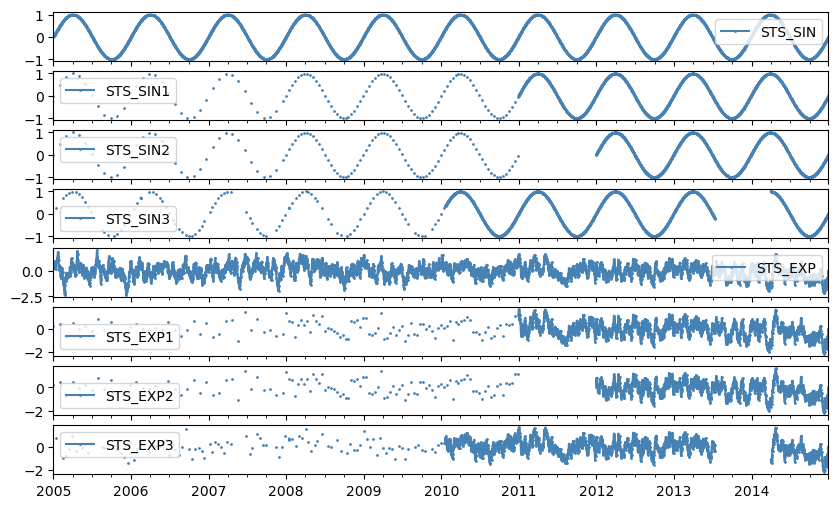

In [2]:
index_test = (
    pd.read_csv(
        "../examples/data/test_index.csv", parse_dates=True, index_col=0, names=["Date"]
    )
    .squeeze()
    .index.ceil("D")
    .unique()
)
n_years = 10
index = pd.to_datetime(np.arange(0, n_years * 365, 1), unit="D", origin="2005")
index.name = "Time [Years]"

# 1. Sine timeseries 1: equal timesteps
np.random.seed(0)
data = np.sin(
    np.linspace(0, n_years * 2 * np.pi, len(index))
)  # +np.random.rand(index.size)
v = pd.Series(data=data, index=index, name="STS_SIN")

# 2. Sine timeseries with three frequencies
v1 = (
    v.iloc[: -7 * 365]
    .asfreq("30D")
    .append(v.iloc[-7 * 365 : -4 * 365].asfreq("14D"))
    .append(v.iloc[-4 * 365 :])
)
v1.name = "STS_SIN1"

# 3. Sine timeseries with three frequencies and a data gap
v2 = (
    v.iloc[: -7 * 365]
    .asfreq("30D")
    .append(v.iloc[-7 * 365 : -4 * 365].asfreq("14D"))
    .append(v.iloc[-3 * 365 :])
)
v2.name = "STS_SIN2"

# 4. Sine timeseries with indices based on a true groundwater level measurement indices
v3 = v.reindex(index_test).dropna()
v3.name = "STS_SIN3"

# Convoluting a random noise process with a exponential decay function to obtain a autocorrelation
# timeseries similar to an Auto Regressive model of order 1 (AR(1))
alpha = 10
np.random.seed(0)
n = np.random.rand(index.size + 365)
b = np.exp(-np.arange(366) / alpha)
n = np.convolve(n, b, mode="valid")
n = n - n.mean()

index = pd.to_datetime(np.arange(0, n.size, 1), unit="D", origin="2005")
index.name = "Time [Years]"
n = pd.Series(data=n, index=index, name="STS_EXP")

n1 = n.reindex(v1.index).dropna()
n1.name = "STS_EXP1"
n2 = n.reindex(v2.index).dropna()
n2.name = "STS_EXP2"
n3 = n.reindex(index_test).dropna()
n3.name = "STS_EXP3"

# Create a DataFrame with all series and plot them all
d = pd.concat([v, v1, v2, v3, n, n1, n2, n3], axis=1)
d.plot(subplots=True, figsize=(10, 6), marker=".", markersize=2, color="steelblue");

## Theoretical autocorrelation
In this codeblock a figure is created showing the time series with equidistant timesteps and their theoretical autocorrelation.

In [3]:
# Compute true autocorrelation functions
acf_v_true = pd.Series(np.cos(np.linspace(0, 2 * np.pi, 365)))
acf_n_true = pd.Series(b)

## Computing the autocorrelation

The autocorrelation function for all time series is calculated for a number of time lags. Two different methods are used:

- binning in a rectangular bin
- weighting through a Gaussian kernel

<div class="alert alert-warning">
    
<b>Warning</b> 
    
Calculation of all the autocorrelation functions can take several minutes!

</div>

In [4]:
lags = np.arange(1.0, 366)
acf_df = pd.DataFrame(index=lags)

for name, sts in d.items():
    for method in ["rectangle", "gaussian"]:
        acf = ps.stats.acf(sts.dropna(), bin_method=method, max_gap=30)
        acf.index = acf.index.days
        acf_df.loc[:, name + "_" + method] = acf

## Autocorrelation for regular time series

Text(0, 0.5, 'Error [L]')

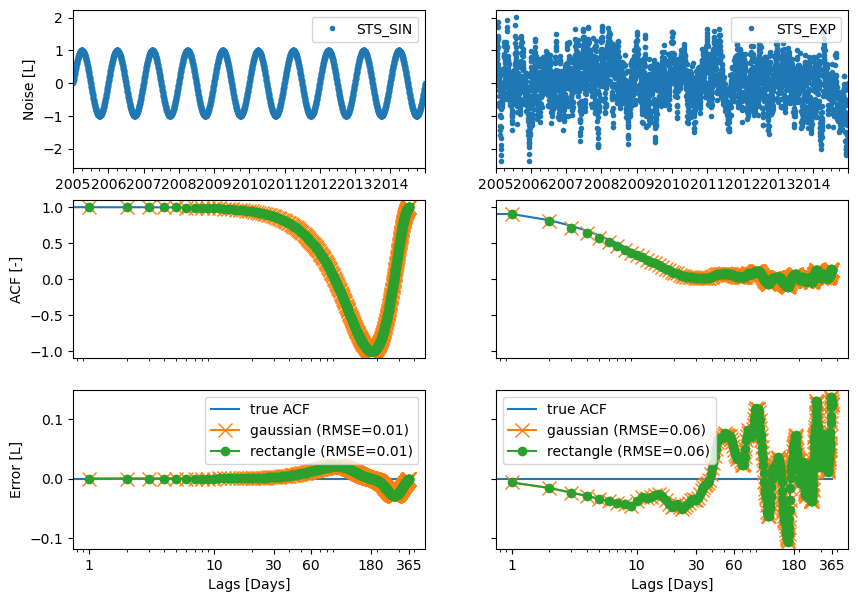

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 7), sharey="row")

for i, name in enumerate(["STS_SIN", "STS_EXP"]):
    sts = d.loc[:, name]
    sts.plot(ax=axes[0][i], style=".", legend=True, label=name)

    if name == "STS_SIN":
        acf_true = acf_v_true
    else:
        acf_true = acf_n_true

    acf_true.plot(ax=axes[1][i])

    axes[2][i].plot([0.0, 365], [0, 0], label="true ACF")
    for bm in ["gaussian", "rectangle"]:
        acf_name = name + "_" + bm
        acf = acf_df.loc[:, acf_name]
        if bm == "gaussian":
            kwargs = dict(marker="x", markersize=10)
        else:
            kwargs = dict(marker="o")
        acf.plot(label=bm, ax=axes[1][i], logx=True, linestyle="", **kwargs)
        dif = acf.subtract(acf_true).dropna()
        rmse = " (RMSE={:.2f})".format(np.sqrt((dif.pow(2)).sum() / dif.size))
        dif.plot(label=bm + rmse, ax=axes[2][i], logx=True, **kwargs)
        axes[2][i].legend()
        axes[1][i].set_xticks([])
        axes[2][i].set_xlabel("Lags [Days]")
        axes[2][i].set_xticks([1, 10, 30, 60, 180, 365])
        axes[2][i].set_xticklabels([1, 10, 30, 60, 180, 365])

ax = axes[0][0].set_ylabel("Noise [L]")
axes[1][0].set_ylabel("ACF [-]")
axes[2][0].set_ylabel("Error [L]")

## Sine wave with non-equidistant timesteps

Text(0, 0.5, 'Error [L]')

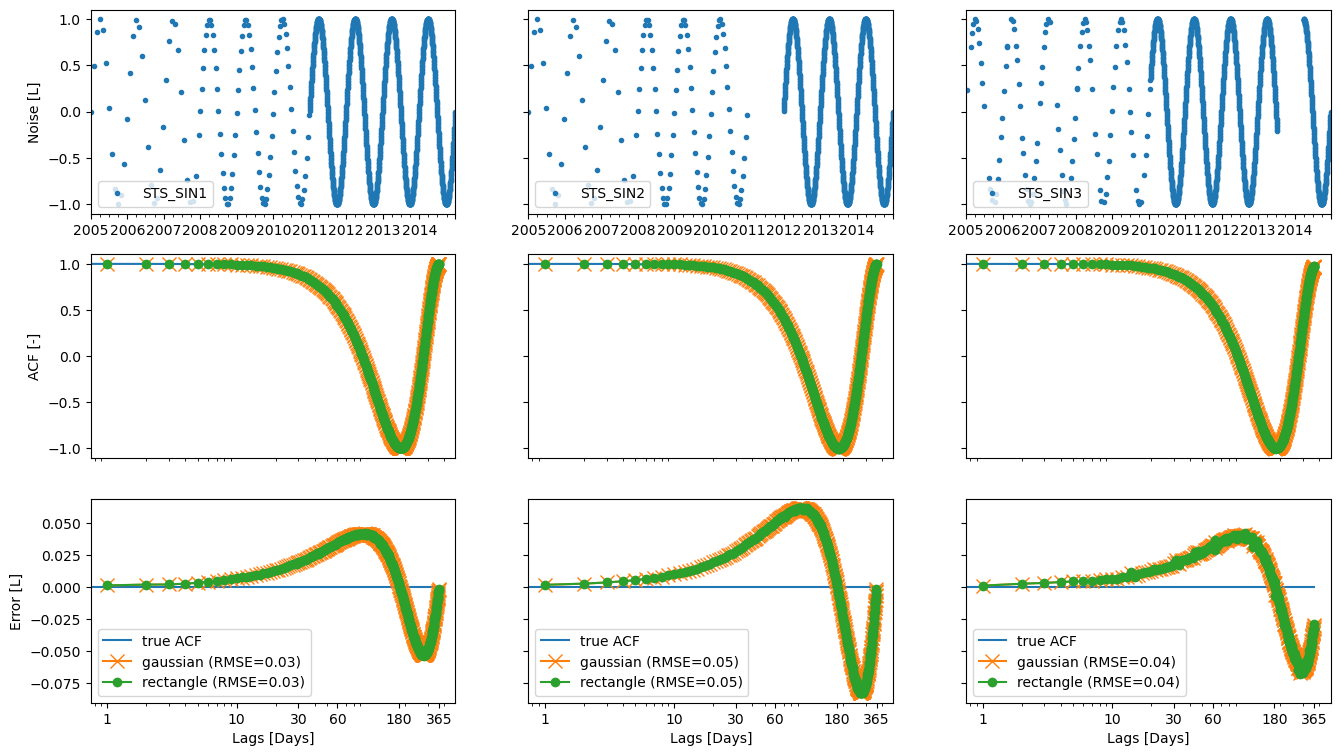

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(16, 9), sharey="row")
#
for i, name in enumerate(["STS_SIN1", "STS_SIN2", "STS_SIN3"]):
    sts = d.loc[:, name]
    sts.plot(ax=axes[0][i], style=".", label=name)
    axes[0][i].legend(loc=3)
    acf_v_true.plot(ax=axes[1][i])
    axes[2][i].plot([0.0, 365], [0, 0], label="true ACF")
    for bm in ["gaussian", "rectangle"]:
        acf_name = name + "_" + bm
        acf = acf_df.loc[:, acf_name]
        if bm == "gaussian":
            kwargs = dict(marker="x", markersize=10)
        else:
            kwargs = dict(marker="o")
        acf.plot(label=bm, ax=axes[1][i], logx=True, linestyle="", **kwargs)
        dif = acf.subtract(acf_v_true).dropna()
        rmse = " (RMSE={:.2f})".format(np.sqrt((dif.pow(2)).sum() / dif.size))
        dif.plot(label=bm + rmse, ax=axes[2][i], logx=True, **kwargs)
        axes[1][i].set_xticks([])
        axes[2][i].set_xticks([1, 10, 30, 60, 180, 365])
        axes[2][i].set_xticklabels([1, 10, 30, 60, 180, 365])
        axes[2][i].legend(loc=3)
        axes[2][i].set_xlabel("Lags [Days]")

axes[2][i].relim()
axes[0][0].set_ylabel("Noise [L]")
axes[1][0].set_ylabel("ACF [-]")
axes[2][0].set_ylabel("Error [L]")

## Exponential decay with non-equidistant timesteps

Text(0, 0.5, 'Difference from true value [-]')

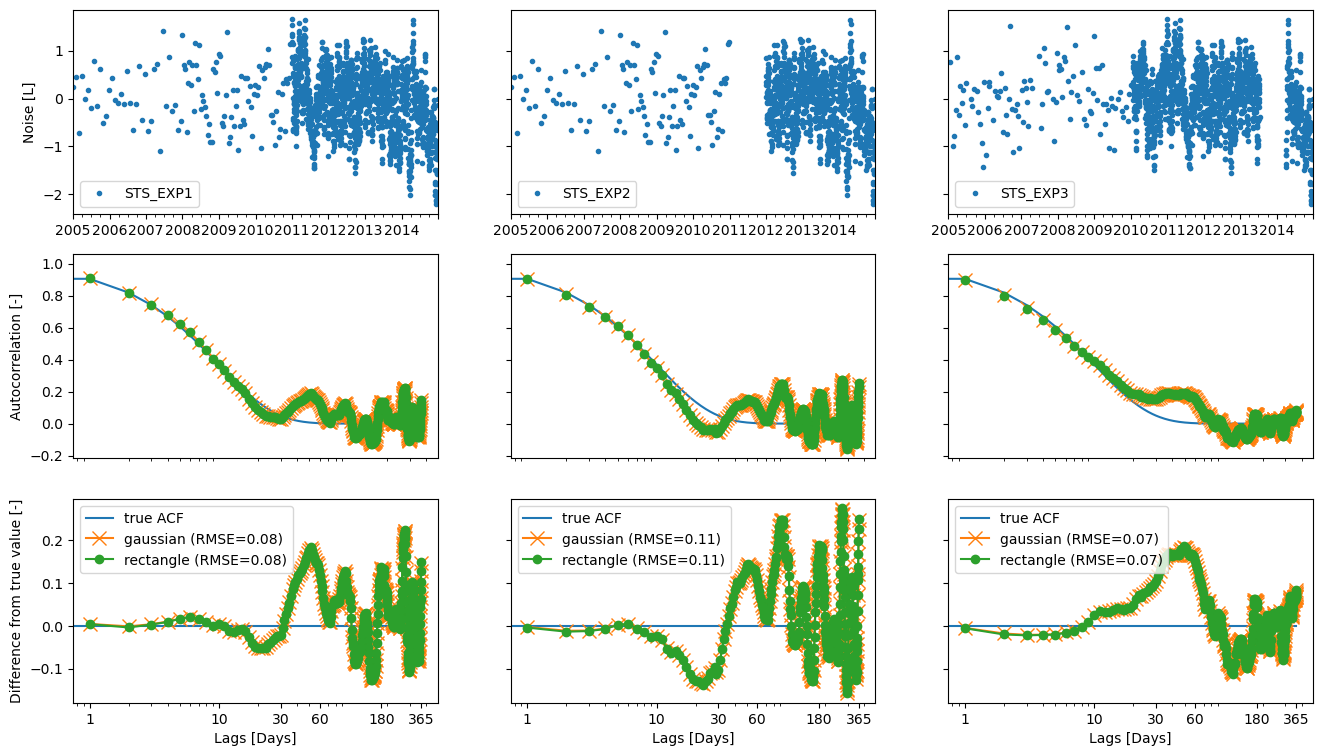

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(16, 9), sharey="row")

for i, name in enumerate(["STS_EXP1", "STS_EXP2", "STS_EXP3"]):
    sts = d.loc[:, name]
    sts.plot(ax=axes[0][i], style=".", label=name)
    axes[0][i].legend(loc=3)
    acf_n_true.plot(ax=axes[1][i])
    axes[2][i].plot([0.0, 365], [0, 0], label="true ACF")
    for j, bm in enumerate(["gaussian", "rectangle"]):
        acf_name = name + "_" + bm
        acf = acf_df.loc[:, acf_name]
        if bm == "gaussian":
            kwargs = dict(marker="x", markersize=10)
        else:
            kwargs = dict(marker="o")
        acf.plot(label=bm, ax=axes[1][i], logx=True, linestyle="", **kwargs)
        dif = acf.subtract(acf_n_true).dropna()
        rmse = " (RMSE={:.2f})".format(np.sqrt((dif.pow(2)).sum() / dif.size))
        dif.plot(label=bm + rmse, ax=axes[2][i], logx=True, sharey=axes[2][0], **kwargs)
        axes[2][i].set_xticks([1, 10, 30, 60, 180, 365])
        axes[2][i].set_xticklabels([1, 10, 30, 60, 180, 365])
        axes[1][i].set_xticks([])
        axes[2][i].legend(loc=2)
        axes[2][i].set_xlabel("Lags [Days]")

axes[0][0].set_ylabel("Noise [L]")
axes[1][0].set_ylabel("Autocorrelation [-]")
axes[2][0].set_ylabel("Difference from true value [-]")

## References
- Rehfeld, K., Marwan, N., Heitzig, J., Kurths, J. (2011). [Comparison of correlation analysis techniques for irregularly sampled time series](https://doi.org/10.5194/npg-18-389-2011). Nonlinear Processes in Geophysics. 18. 389-404.
- Edelson, R. A., & Krolik, J. H. (1988). The discrete correlation function-A new method for analyzing unevenly sampled variability data. The Astrophysical Journal, 333, 646-659.
- Collenteur, R.A. (2018) [Over autocorrelatie van tijdreeksmoddellen met niet-equidistante tijdstappen](http://www.artesia-water.nl/wp-content/uploads/Autocorrelatie_niet_gelijke_tijdstappen.pdf), Artesia, Schoonhoven, Nederland. In Dutch.